## Практика

In [27]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import statsmodels
import scipy
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

Провести исследование изменился ли средний чек покупок клиентов (колонки revenue)
в интернет магазине есть 2-ва типа продуктов:
* 100 руб.
* 250 руб.

ну и конечно клиент может ничего не купить


In [19]:
# Прочитаем данные из файла ab_datas.csv
df = pd.read_csv('ab_datas.csv')

df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


In [20]:
df['revenue'].value_counts()

0      123000
250     85863
100     85615
Name: revenue, dtype: int64

Посетителей из контрольной `control` группы должны были направлять на страницу в старом дизайне  `old_page` , пользователей из тестовой группы `treatment` - на страницу в новом дизайне `new_page`. Проверим, были ли ошибки при направлении.

In [21]:
mismatch_1 = df.query("group == 'treatment' and landing_page == 'old_page'")
print("Из тестовой группы неверно направлены {}".format(len(mismatch_1)) + " пользователей")

mismatch_2 = df.query("group == 'control' and landing_page == 'new_page'")
print("Из контрольной группы неверно направлены  {}".format(len(mismatch_2)) + " пользователей")

Из тестовой группы неверно направлены 1965 пользователей
Из контрольной группы неверно направлены  1928 пользователей


Выясним, есть ли в данных пропуски.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   revenue       294478 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 10.1+ MB


Пропущенных значений нет.

Посчитаем средний чек для всех посетителей

In [23]:
mean = df['revenue'].mean()
print(f'Средний чек по всем посетителям: {mean}')

Средний чек по всем посетителям: 101.9677191504968


In [24]:
df_grp = df[['group', 'revenue']].groupby('group')
df_grp.describe()

revenue                                                       
              count        mean         std  min  25%    50%    75%    max
group                                                                     
control    147202.0   87.431896  102.424926  0.0  0.0    0.0  250.0  250.0
treatment  147276.0  116.496238  102.732069  0.0  0.0  100.0  250.0  250.0

In [25]:
#объем тестовой группы
n_rows = df.shape[0]
n_rows_treat = len(df[df['group'] == 'treatment'])

#объем контрольной группы
n_rows_contr = n_rows-n_rows_treat

print("Соотношение размеров тестовой и контрольной групп: {}".format(n_rows_treat/n_rows_contr))

print("Вероятность, что новый пользователь будет направлен на версию со старым дизайном: {}".format(n_rows_treat/n_rows))
print("Вероятность, что новый пользователь будет направлен на версию с новым дизайном: {}".format(n_rows_contr/n_rows))

Соотношение размеров тестовой и контрольной групп: 1.0005027105609978
Вероятность, что новый пользователь будет направлен на версию со старым дизайном: 0.5001256460584492
Вероятность, что новый пользователь будет направлен на версию с новым дизайном: 0.49987435394155083


#### Формулировка рабочей гипотезы

"Средний чек посетителя сайта со старым дизайном не меньше, чем с новым"

$H_{0}$ : $\theta_{new}$ <= $\theta_{old}$ 

$H_{1}$ : $\theta_{new}$ > $\theta_{old}$ 

На основании Закона больших чисел мы можем оценить средние значения случайных величин $\theta_{new}$ и $\theta_{old}$ на  генеральных совокупностях по их средним значениям на наших больших выборках. Нам нужно выяснить, случайно или значимо отличаются средние значения в контрольной и тестовой выборках. Так как дисперсия генеральной совокупности неизвестна, то будем использовать критерий Стьюдента.

In [28]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df.query("group == 'treatment'")['revenue'],
                                                              df.query("group == 'control'")['revenue'],
                                                              alternative="larger",
                                                              usevar='unequal')
print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=76.8776779597559,  p_value=0.0


Нулевая гипотеза отклоняется, т.е. средний чек посетителя сайта со старым дизайном меньше, чем с новым.

In [31]:
# Проведение вычислений.𝑀𝑎𝑛𝑛–𝑊ℎ𝑖𝑡𝑛𝑒𝑦-test
w_score, p_value = scipy.stats.mannwhitneyu(df.query("group == 'treatment'")['revenue'], 
                         df.query("group == 'control'")['revenue'],
                         alternative="greater")
print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=12643398633.5,  p_value=0.0


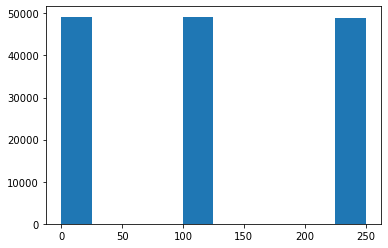

In [32]:
plt.hist(df.loc[df['group']=='treatment', 'revenue']);

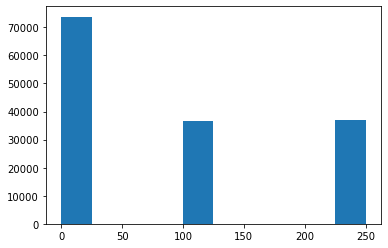

In [33]:
plt.hist(df.loc[df['group']=='control', 'revenue']);

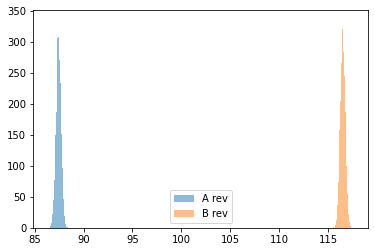

In [34]:
b = df.loc[df['group']=='treatment', 'revenue'].values
a = df.loc[df['group']=='control', 'revenue'].values
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

plt.hist(a_means, label='A rev', alpha=0.5, bins=100)
plt.hist(b_means, label='B rev', alpha=0.5, bins=100)

plt.legend()
plt.show()

In [35]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(86.9125419491583, 87.94548477602207)

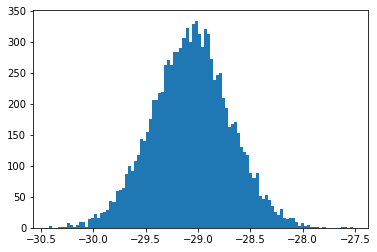

In [36]:
plt.hist(a_means - b_means, bins=100)
plt.show()

In [38]:
# сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.0

## Теория

### 1. Если мы рассчитали 95% доверительный интервал для среднего значения, то какие из следующих утверждений являются верными?

Ответ: 
* 2) Мы можем быть на 95% уверены, что среднее значение в генеральной совокупности принадлежит рассчитанному доверительному интервалу.
* 3) Если многократно повторять эксперимент, для каждой выборки рассчитывать свой доверительный интервал, то в 95 % случаев истинное среднее будет находиться внутри доверительного интервала.

### 2. Если мы увеличиваем объем выборки в два раза (при условии, что показатель стандартного отклонения остается неизменным), то 95% доверительный интервал

Ответ: 1) стал более узким     

### 3. В центре 95% доверительного интервала, рассчитанного по выборочным значениям, находится:

Ответ: 2) Выборочное среднее значение 

### 4. Часто на практике нулевая гипотеза отклоняется, и различия считаются статистически достоверными, если p < 0,05. Однако часто в статистике используется более жесткий критерий достоверности различий, например, при условии, что p < 0,01. Значение p-уровня значимости, которое выбирается, в качестве порога обозначается буквой α (альфа). Например, если исследователь решил, что α = 0,05, то и нулевая гипотеза будет отклоняться при условии, что p < 0,05.  Если в определенной ситуации весьма рискованно отклонить нулевую гипотезу, когда она на самом деле верна, то лучше использовать показатель α равный


Ответ: 2) 0,001 

### 5. Данные некоторого исследования сообщают нам, что средний рост детей в 14 лет составляет 166 сантиметров. Однако это лишь выборочная оценка, и исследователи рассчитали 95% доверительный интервал, который составил [160, 172]. Укажите верные утверждения:

Ответ: 
* 1) У нас достаточно оснований отклонить нулевую гипотезу, что среднее в генеральной совокупности равняется 173 
* 3) У нас достаточно оснований отклонить нулевую гипотезу, что среднее в генеральной совокупности равняется 158

### 6. Предположим, нулевой гипотезой вашего исследования являлось предположение, что конверсия в генеральной совокупности равняется 0.4. Вы получили p = 0,12 и не смогли отклонить нулевую гипотезу. Однако позже выяснилось, что конверсия в генеральной совокупности действиетльно равна 0.4. Как можно оценить результаты?

Ответ: 1) Вы не совершали ни ошибку первого рода, ни ошибку второго рода.